# Vårt superprosjekt

## a

We initalize and test the functionality of Qiskit as follows

In [223]:
from qiskit import QuantumCircuit,Aer,assemble, ClassicalRegister,QuantumRegister
from qiskit.visualization import array_to_latex, plot_histogram
import numpy as np
import matplotlib.pyplot as plt
simulator = Aer.get_backend('aer_simulator')

In [224]:
qr = QuantumRegister(1, 'Qreg')
cr = ClassicalRegister(1, 'Creg')

qc = QuantumCircuit()
qc.add_register(qr)
qc.add_register(cr)
#qc.save_statevector()

qc.x(0)
qc.y(0)
qc.z(0)
qc.h(0)
qc.p(np.pi/2, 0)


qc.draw()

┌───┐┌───┐┌───┐┌───┐┌────────┐
  Qreg: ┤ X ├┤ Y ├┤ Z ├┤ H ├┤ P(π/2) ├
        └───┘└───┘└───┘└───┘└────────┘
Creg: 1/══════════════════════════════

Initialize a Bell state by applying Haddamard to G0 and CNOT on G1, using G0 as control gate.

In [225]:
qc_2 = QuantumCircuit()

qr_2 = QuantumRegister(2, 'qreg')
qc_2.add_register(qr_2)

cr_2 = ClassicalRegister(2, 'creg')
qc_2.add_register(cr_2)
qc_2.h(0)
qc_2.cx(0,1)
qc_2.save_statevector()
qc_2.measure(qr_2[0], cr_2[0])
qc_2.measure(qr_2[1], cr_2[1])
qc_2.draw()

┌───┐      statevector ┌─┐   
qreg_0: ┤ H ├──■────────░──────┤M├───
        └───┘┌─┴─┐      ░      └╥┘┌─┐
qreg_1: ─────┤ X ├──────░───────╫─┤M├
             └───┘      ░       ║ └╥┘
creg: 2/════════════════════════╩══╩═
                                0  1

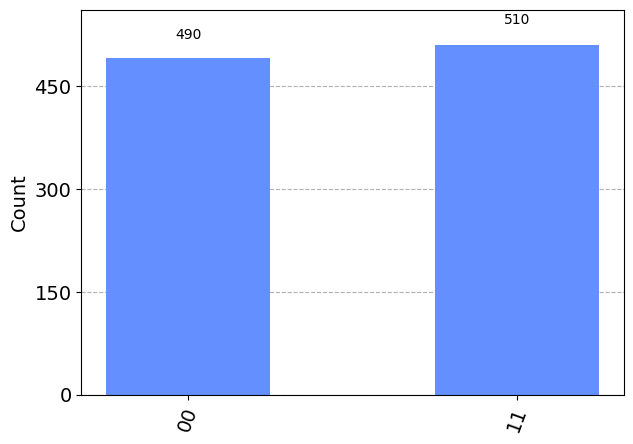

In [226]:
job = simulator.run(qc_2, shots=1000)
hist = job.result().get_counts()
plot_histogram(hist)

This is statistically in accordance with the expected Bell states.

## b


Here we initialize the Hamiltonian matrices and solve it using eigsolvers.


[[2.         0.13333333]
 [0.13333333 2.        ]]

[2.13333333 1.86666667] 

 [[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


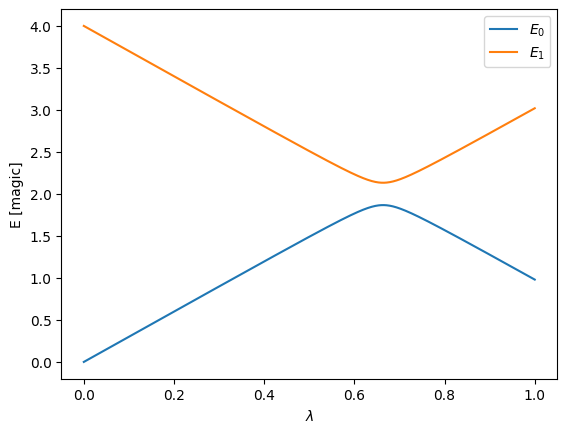

In [227]:
H0 = np.eye(2)
E1 = 0; E2 = 4
H0[0,0] = E1; H0[1,1] = E2


H1 = np.eye(2)
v11 = 3; v22 = -v11; v12 = 0.2; v21 = v12
H1[0,0] = v11; H1[0,1] = v12; H1[1,0] = v21; H1[1,1] = v22 

lmd_ = 2/3#Range [0,1]
pauli_x = np.matrix([[0,1],[1,0]])
pauli_z = np.matrix([[1,0],[0,-1]])
c = (v11 + v22)/2
omega_z = (v11-v22)/2
omega_x = v12

H_ = H0 + lmd_*H1

print(H_)
print()
eig_val, eig_vec = np.linalg.eig(H_)
print(eig_val,'\n\n', eig_vec)


n = 1000
lambdas = np.linspace(0,1,n)
Es = np.zeros((n,2))
C1s, C2s  = np.zeros_like(Es), np.zeros_like(Es)
for i, lmd_ in enumerate(lambdas):
    H_ = H0 + lmd_*H1
    eig_val, eig_vec = np.linalg.eigh(H_)
    # print(H_)
    Es[i,:] = eig_val
    C1s[i,:] = eig_vec[:,0]
    C2s[i,:] = eig_vec[:,1] 

fig, ax = plt.subplots()
ax.plot(lambdas, Es[:,0], label=r"$E_0$")
ax.plot(lambdas, Es[:,1], label=r"$E_1$")
ax.set(xlabel=r"$\lambda$", ylabel="E [magic]")
ax.legend() # Kan legge til fancy-pancy color bar for a vise "change of character" opplegget?

## c


In [228]:
from qiskit.algorithms.minimum_eigensolvers import VQE
from functools import partial
from scipy.optimize import minimize
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.opflow import X, Z, I

optimizer = partial(minimize, method="L-BFGS-B")

[0.59196649 0.51093844]


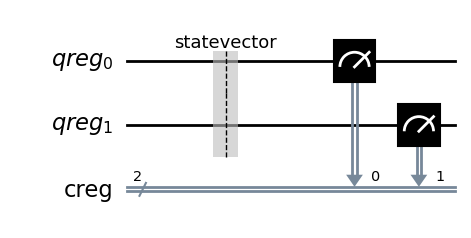

In [229]:
qc_3 = QuantumCircuit()

qr_3 = QuantumRegister(2, 'qreg')
qc_3.add_register(qr_3)

cr_3 = ClassicalRegister(2, 'creg')
qc_3.add_register(cr_3)

eta = (E1 + E2)/2
Omega = (E1-E2)/2
H0 = eta*np.eye(2) + Omega*pauli_z
are = Operator(Pauli('X'))

H1 = c * np.eye(2) + omega_z * pauli_z + omega_x * pauli_x
#I = Operator( Pauli('X') )

X_op = Operator(Pauli('X'))
Z_op = Operator(Pauli('Z'))
idty = Operator(np.eye(2))
#c_op = Operator(Multiply(0.3))

#X_op.multiply(1)
#op_ = eta*idty + Omega*Z_op + lmd_*(c*idty + omega_z*Z_op + omega_x * X_op)
#print(op_.is_unitary())
#Trenger en unitær operator for å klare å implementere det. Noen idé?

print(np.random.randn(2))


qc_3.save_statevector()
qc_3.measure(qr_3[0], cr_3[0])
qc_3.measure(qr_3[1], cr_3[1])
qc_3.draw('mpl')

## Mortenmåten

In [230]:
I = np.eye(2)
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])

H0 = np.kron(I,I) + np.kron(Z,I)
H1 = np.kron(I,I) + np.kron(I,Z) + np.kron(I,X) 
 
H_tot = H0 + H1

print(H_tot)

[[4. 1. 0. 0.]
 [1. 2. 0. 0.]
 [0. 0. 2. 1.]
 [0. 0. 1. 0.]]


In [231]:
c = (v11 + v22)/2
omega_z = (v11-v22)/2
omega_x = v12
eta = (E1+E2)/2
omega_ = (E1-E2)/2

h1_val = c + eta
h2_val = omega_
h3_val = omega_z
h4_val = omega_x

h1 = [h1_val, [0,1] , ['I']]
h2 = [h2_val, [0] , ['Z']]
h3 = [h3_val, [1] , ['Z']]
h4 = [h4_val, [1] , ['X']]

H = [h1,h2,h3,h4]
H

[[2.0, [0, 1], ['I']],
 [-2.0, [0], ['Z']],
 [3.0, [1], ['Z']],
 [0.2, [1], ['X']]]

In [232]:
def ansatz(theta,n_qubits):
    qreg = QuantumRegister(n_qubits)
    circuit = QuantumCircuit(qreg)
    for i in range(n_qubits):
        circuit.ry(theta[i],qreg[i])
    for i in range(n_qubits-1):
        circuit.cx(qreg[i],qreg[i+1])
    return(circuit)


Before ansatz


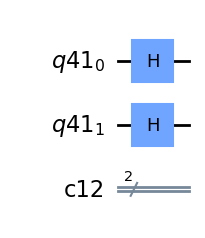

In [244]:
n_qbits = 2
theta = np.random.randn(2)

qc = QuantumCircuit()
qreg = QuantumRegister(2)
creg = ClassicalRegister(2)

qc.add_register(qreg)
qc.add_register(creg)
qc.h(qreg[:])

print('Before ansatz')
qc.draw('mpl')


After ansatz


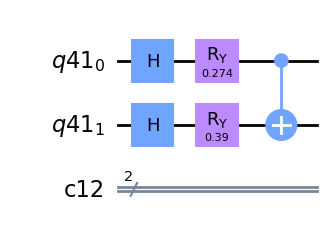

In [245]:
qc = qc.compose(ansatz(theta,n_qbits))
print('After ansatz')
qc.draw('mpl')

In [246]:
def basis_change(h_i,n_qubits):
    qreg = QuantumRegister(n_qubits)
    circuit = QuantumCircuit(qreg)
    
    
    ##Må nok modifisere denne  litt da den kanskje er litt for genrell
    for qubit,operator in zip(h_i[1],h_i[2]):
        if operator == 'X':
            circuit.h(qreg[qubit])
        if operator == 'Z':
            circuit.sdg(qreg[qubit])   ##Litt usikker på hvorfor vi bruker SDG
            circuit.h(qreg[qubit])
    return(circuit)

After basis transformation:


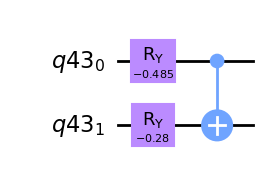

In [247]:
n_qubits = 2
theta = np.random.randn(n_qubits)

qreg = QuantumRegister(n_qubits)
qc = QuantumCircuit(qreg)
qc = qc.compose(ansatz(theta,n_qubits))
qc = qc.compose(basis_change(H[0],n_qubits))
print('After basis transformation:')
qc.draw('mpl')

In [249]:
def get_energy(theta):
    n_qubits = 2
    qreg = QuantumRegister(n_qubits)
    qc = QuantumCircuit(qreg)
    qc = qc.compose(ansatz(theta,n_qubits))
    qc_list = []
    for idx,h_i in enumerate(H):
        basis_change_circuit = basis_change(h_i,n_qubits)
        new_qc = qc.compose(basis_change_circuit)
        creg = ClassicalRegister(len(h_i[1]))
        new_qc.add_register(creg)
        new_qc.measure(qreg[h_i[1]],creg)
        qc_list.append(new_qc)
        
    shots = 10000
    job = simulator.run(qc_list,shots=shots)
    E = np.zeros(len(qc_list))
    for i in range(len(E)):
        result = job.result()
        counts = result.get_counts(i)
        for key,value in counts.items():
            e = 1
            for bit in key:
                if bit == '0':
                    e *= 1
                if bit == '1':
                    e *= -1
            E[i] += e*value
        E[i] *= H[i][0]
    E /= shots
    return(np.sum(E))

theta = np.random.randn(2)
get_energy(theta)

1.52536

In [251]:
theta = np.random.randn(2)
res = minimize(get_energy, theta, method='Powell',tol=1e-12)
get_energy(res.x)

-2.05464

In [252]:
epochs = 200
theta = np.random.randn(4)
for epoch in range(epochs):
    print(epoch,get_energy(theta))
    grad = np.zeros_like(theta)
    for idx in range(theta.shape[0]):
        theta_temp = theta.copy()
        theta_temp[idx] += np.pi/2
        E_plus = get_energy(theta_temp)
        theta_temp[idx] -= np.pi
        E_minus = get_energy(theta_temp)
        grad[idx] = (E_plus - E_minus)/2
    theta -= 0.1*grad

0 1.93108
1 1.83308
2 1.77976
3 1.67504
4 1.45232
5 1.3544400000000003
6 1.04632
7 0.7652000000000001
8 0.48848
9 0.06664
10 -0.32696000000000003
11 -0.6984400000000001
12 -1.0786
13 -1.3577199999999998
14 -1.51552
15 -1.70236
16 -1.8674
17 -1.85036
18 -1.9603599999999999
19 -1.9395600000000002
20 -1.92708
21 -1.98036
22 -2.01452
23 -2.0609999999999995
24 -2.02444
25 -1.92056
26 -2.03892
27 -2.01212
28 -2.07
29 -1.9982
30 -1.98428
31 -2.01304
32 -1.97636
33 -1.9496
34 -1.9657600000000002
35 -1.9785199999999998
36 -2.0876
37 -2.03328
38 -2.01764
39 -1.9700399999999998
40 -1.9866000000000001
41 -1.9602400000000002
42 -1.98512
43 -1.98528
44 -1.9596799999999999
45 -1.97908
46 -2.04684
47 -1.9612
48 -1.9744800000000002
49 -1.97556
50 -1.9878799999999999
51 -1.9311600000000002
52 -2.0552799999999998
53 -1.9964
54 -2.04536
55 -2.01436
56 -2.0155600000000002
57 -2.09088
58 -1.96844
59 -2.0658
60 -2.01812
61 -2.0594
62 -1.9967599999999999
63 -1.9932800000000002
64 -1.99344
65 -2.02536
66 -2.07

In [327]:
#1d
#Skal gjennomføres som funksjon av lambda, tar det siden
lmd_ = 0.8
s_00 = np.array([1,0,0,0])
s_10 = np.array([0,1,0,0])
s_01 = np.array([0,0,1,0])
s_11 = np.array([0,0,0,1])
#Kan eventuelt bruke np.kron( [1,0], [0,1])
        
eps_list = [0,2.5,6.5,7]
H0 = np.eye(4)
H0[0,0] = eps_list[0];H0[1,1] = eps_list[1];H0[2,2] = eps_list[2];H0[3,3] = eps_list[3]

pauli_x = np.matrix([[0,1],[1,0]])
pauli_z = np.matrix([[1,0],[0,-1]])
H_x = 2.0
H_z = 3.0
H_I = H_x * np.kron(pauli_x, pauli_x) + H_z * np.kron(pauli_z, pauli_z)

H_tot = H0 + lmd_*H_I
#print(H_tot)

eig_vals, eig_vecs = np.linalg.eig(H_tot)
#print(eig_vals) 
#print()
#print(eig_vecs)

#Computing partial density matrix
rho_a = (eig_vecs[0].max() + eig_vecs[1].max()) * np.outer(s_00,s_00) + (eig_vecs[2].max() + eig_vecs[3].max()) * np.outer(s_11,s_11)
rho_b = (eig_vecs[0].max() + eig_vecs[2].max()) * np.outer(s_00,s_00) + (eig_vecs[1].max() + eig_vecs[3].max()) * np.outer(s_11,s_11)

#Compute entropy
S_a = - np.trace(rho_a)*np.log2(np.trace(rho_a))
S_b = - np.trace(rho_b)*np.log2(np.trace(rho_b))
S_a, S_b

(-3.207020335903938, -3.207020335903938)

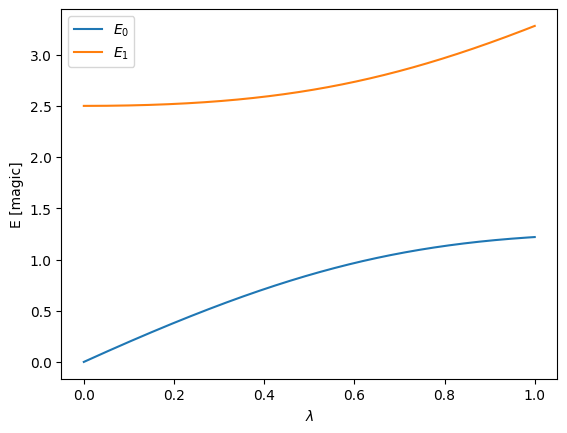

In [344]:
n = 1000
lambdas = np.linspace(0,1,n)
Es = np.zeros((n,4))
C1s, C2s  = np.zeros_like(Es), np.zeros_like(Es)

for i, lmd_ in enumerate(lambdas):
    H_ = H0 + lmd_*H1
    eig_val, eig_vec = np.linalg.eigh(H_)
    #print(eig_val)
    #print(eig_vec.shape)
    Es[i,:] = eig_val
    #C1s[i,:] = eig_vec[:,0]
    #C2s[i,:] = eig_vec[:,1] 

fig, ax = plt.subplots()
ax.plot(lambdas, Es[:,0], label=r"$E_0$")
ax.plot(lambdas, Es[:,1], label=r"$E_1$")
ax.set(xlabel=r"$\lambda$", ylabel="E [magic]")
ax.legend() # Kan legge til fancy-pancy color bar for a vise "change of character" opplegget?

The entropy is as expected, similar, as there are no difference in the configuration of the two states. As such, there should be an equal amount of entanglement entropy. The energies follow the same asymptotic convergence, which indeed confirms their entanglement.

## Stian-måten


In [400]:
import numpy as np
import qiskit as qk
from scipy.optimize import minimize
simulator = qk.Aer.get_backend('qasm_simulator') 

In [409]:
n_qubits = 2
n_cbits = 2
qreg = qk.QuantumRegister(n_qubits)
creg = qk.ClassicalRegister(n_cbits)
circuit = qk.QuantumCircuit(qreg,creg)

In [424]:
I = np.eye(2)
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
hx = 2; hz = 3; eps_list = [0,2.5,6.5,7]

H_0 = np.matrix([[eps_list[0],0,0,0],[0,eps_list[1],0,0],[0,0,eps_list[2],0],[0,0,0,eps_list[3]]])
H_I = hx * np.kron(X,X) + hz* np.kron(Z,Z) 
H = H_0 + H_I
eigvals,eigvecs = np.linalg.eigh(H)
print(eigvals)
print(eigvecs)

c_1 = 1
c_2 = 1
c_3 = 1

h_1 = [c_1,[0],['z,z']]
h_2 = [c_2,[1],['x,x']]
H = [h_1,h_2,h_3]

[-1.32842712  2.46887113  4.32842712 10.53112887]
[[-0.         -0.96649965  0.         -0.25666794]
 [ 0.92387953  0.         -0.38268343  0.        ]
 [-0.38268343  0.         -0.92387953  0.        ]
 [ 0.          0.25666794  0.         -0.96649965]]


In [425]:
def ansatz(theta,n_qubits):
    qreg = qk.QuantumRegister(n_qubits)
    circuit = qk.QuantumCircuit(qreg)
    for i in range(n_qubits):
        circuit.ry(theta[i],qreg[i])
    for i in range(n_qubits-1):
        circuit.cx(qreg[i],qreg[i+1])
    return(circuit)

qreg = qk.QuantumRegister(n_qubits)
circuit = qk.QuantumCircuit(qreg)
circuit.h(qreg[:2])
print('Before ansatz')
print(circuit.draw())
theta = np.random.randn(2)
n_qubits = 2
circuit = circuit.compose(ansatz(theta,n_qubits))
print('After ansatz')
print(circuit.draw())

Before ansatz
          ┌───┐
q40806_0: ┤ H ├
          ├───┤
q40806_1: ┤ H ├
          └───┘
After ansatz
          ┌───┐ ┌────────────┐      
q40806_0: ┤ H ├─┤ Ry(1.5842) ├───■──
          ├───┤┌┴────────────┴┐┌─┴─┐
q40806_1: ┤ H ├┤ Ry(0.052918) ├┤ X ├
          └───┘└──────────────┘└───┘


In [432]:
def basis_change(h_i,n_qubits):
    qreg = qk.QuantumRegister(n_qubits)
    circuit = qk.QuantumCircuit(qreg)
    
    for qubit,operator in zip(h_i[1],h_i[2]):
        if operator == 'x':
            circuit.h(qreg[qubit])
        if operator == 'z':
            #circuit.sdg(qreg[qubit])
            circuit.h(qreg[qubit])
    return(circuit)
n_qubits = 2
qreg = qk.QuantumRegister(n_qubits)
circuit = qk.QuantumCircuit(qreg)
theta = np.random.randn(n_qubits)
circuit = circuit.compose(ansatz(theta,n_qubits))
print('Ansatz circuit')
print(circuit.draw())
circuit = circuit.compose(basis_change(H[2],n_qubits))
print('After basis transformation:')
print(circuit.draw())

Ansatz circuit
           ┌───────────┐       
q40826_0: ─┤ Ry(2.306) ├────■──
          ┌┴───────────┴─┐┌─┴─┐
q40826_1: ┤ Ry(-0.19752) ├┤ X ├
          └──────────────┘└───┘
After basis transformation:
           ┌───────────┐       ┌───┐
q40826_0: ─┤ Ry(2.306) ├────■──┤ H ├
          ┌┴───────────┴─┐┌─┴─┐├───┤
q40826_1: ┤ Ry(-0.19752) ├┤ X ├┤ H ├
          └──────────────┘└───┘└───┘


In [433]:
def get_energy(theta):
    n_qubits = 2
    qreg = qk.QuantumRegister(n_qubits)
    circuit = qk.QuantumCircuit(qreg)
    circuit = circuit.compose(ansatz(theta,n_qubits))
    circuit_list = []
    for idx,h_i in enumerate(H):
        basis_change_circuit = basis_change(h_i,n_qubits)
        new_circuit = circuit.compose(basis_change_circuit)
        creg = qk.ClassicalRegister(len(h_i[1]))
        new_circuit.add_register(creg)
        new_circuit.measure(qreg[h_i[1]],creg)
        circuit_list.append(new_circuit)
    shots = 10000
    job = backend.run(circuit_list,shots=shots)
    E = np.zeros(len(circuit_list))
    for i in range(len(circuit_list)):
        result = job.result()
        counts = result.get_counts(i)
        for key,value in counts.items():
            e = 1
            for bit in key:
                if bit == '0':
                    e *= 1
                if bit == '1':
                    e *= -1
            E[i] += e*value
        E[i] *= H[i][0]
    E /= shots
    return(np.sum(E))

theta = np.random.randn(2)
get_energy(theta)

-0.5294

In [436]:
#Minimize the data
theta = np.random.randn(2)
res = minimize(get_energy, theta, method='Powell',tol=1e-12)
get_energy(res.x)



-2.2426

In [437]:
"""
## We might need a more flexible ansatz
def ansatz(theta,n_qubits):
    qreg = qk.QuantumRegister(n_qubits)
    circuit = qk.QuantumCircuit(qreg)
    idx = 0
    for i in range(n_qubits):
        circuit.ry(theta[idx],qreg[i])
        idx += 1
    for i in range(n_qubits-1):
        circuit.cx(qreg[i],qreg[i+1])
    for i in range(n_qubits):
        circuit.rx(theta[idx],qreg[i])
        idx += 1
    for i in range(n_qubits-1):
        circuit.cx(qreg[i],qreg[i+1])
    return(circuit)
theta = np.random.randn(4)
res = minimize(get_energy, theta, method='Powell',tol=1e-16)
get_energy(res.x)
"""

"\n## We might need a more flexible ansatz\ndef ansatz(theta,n_qubits):\n    qreg = qk.QuantumRegister(n_qubits)\n    circuit = qk.QuantumCircuit(qreg)\n    idx = 0\n    for i in range(n_qubits):\n        circuit.ry(theta[idx],qreg[i])\n        idx += 1\n    for i in range(n_qubits-1):\n        circuit.cx(qreg[i],qreg[i+1])\n    for i in range(n_qubits):\n        circuit.rx(theta[idx],qreg[i])\n        idx += 1\n    for i in range(n_qubits-1):\n        circuit.cx(qreg[i],qreg[i+1])\n    return(circuit)\ntheta = np.random.randn(4)\nres = minimize(get_energy, theta, method='Powell',tol=1e-16)\nget_energy(res.x)\n"

In [435]:
##Gradient descent
epochs = 200
theta = np.random.randn(4)
for epoch in range(epochs):
    print(epoch,get_energy(theta))
    grad = np.zeros_like(theta)
    for idx in range(theta.shape[0]):
        theta_temp = theta.copy()
        theta_temp[idx] += np.pi/2
        E_plus = get_energy(theta_temp)
        theta_temp[idx] -= np.pi
        E_minus = get_energy(theta_temp)
        grad[idx] = (E_plus - E_minus)/2
    theta -= 0.1*grad

0 -1.3048
1 -1.5326
2 -1.7578
3 -1.8776
4 -1.9904000000000002
5 -2.0472
6 -2.0814
7 -2.1391999999999998
8 -2.1466
9 -2.1732
10 -2.2024
11 -2.1962
12 -2.1955999999999998
13 -2.222
14 -2.2322
15 -2.2142
16 -2.214
17 -2.2434
18 -2.2256
19 -2.2564
20 -2.2346000000000004
21 -2.2304
22 -2.2292
23 -2.2199999999999998
24 -2.2154000000000003
25 -2.2348
26 -2.234
27 -2.2072
28 -2.2458
29 -2.2596
30 -2.2372
31 -2.2368
32 -2.2216
33 -2.2242
34 -2.231
35 -2.2446
36 -2.2212
37 -2.246
38 -2.24
39 -2.2392
40 -2.257
41 -2.2306
42 -2.2302
43 -2.2322
44 -2.2254
45 -2.2388
46 -2.235
47 -2.2134
48 -2.2256
49 -2.2482
50 -2.253
51 -2.23
52 -2.2468000000000004
53 -2.2392
54 -2.2721999999999998
55 -2.2468
56 -2.2316
57 -2.2184
58 -2.237
59 -2.2081999999999997
60 -2.2456
61 -2.2268
62 -2.2208
63 -2.2356
64 -2.2216
65 -2.239
66 -2.2278
67 -2.2288
68 -2.236
69 -2.2372
70 -2.245
71 -2.259
72 -2.2452
73 -2.2344
74 -2.2406
75 -2.2157999999999998
76 -2.2534
77 -2.2358000000000002
78 -2.2356
79 -2.2276
80 -2.2492
81 -